# Load & Summarize

In [1]:
data_url <- 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'
data <- read.csv(data_url, header=FALSE, sep=",")
colnames(data) <- c("age", "workclass", "fnlwgt", "education", "education_num", 
                    "marital_status", "occupation", "relationship", "race", "sex", 
                    "capital_gain", "capital_loss", "hours_per_week", "native_country", "income")


In [2]:
# Print the dimension of the data
print(dim(data))

[1] 32561    15


In [3]:
head(data,3)

age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K


In [4]:
# Print the summary of the data
print(summary(data))

      age                    workclass         fnlwgt       
 Min.   :17.00    Private         :22696   Min.   :  12285  
 1st Qu.:28.00    Self-emp-not-inc: 2541   1st Qu.: 117827  
 Median :37.00    Local-gov       : 2093   Median : 178356  
 Mean   :38.58    ?               : 1836   Mean   : 189778  
 3rd Qu.:48.00    State-gov       : 1298   3rd Qu.: 237051  
 Max.   :90.00    Self-emp-inc    : 1116   Max.   :1484705  
                 (Other)          :  981                    
         education     education_num                  marital_status 
  HS-grad     :10501   Min.   : 1.00    Divorced             : 4443  
  Some-college: 7291   1st Qu.: 9.00    Married-AF-spouse    :   23  
  Bachelors   : 5355   Median :10.00    Married-civ-spouse   :14976  
  Masters     : 1723   Mean   :10.08    Married-spouse-absent:  418  
  Assoc-voc   : 1382   3rd Qu.:12.00    Never-married        :10683  
  11th        : 1175   Max.   :16.00    Separated            : 1025  
 (Other)      : 5134  

# Setup Testing & Training DAta

In [5]:
num_obs = nrow(data)

set.seed(98004) 

index_shuffled <- sample(num_obs)
training_ratio <- 0.8
training_size <- round(num_obs * training_ratio)
training_index <- index_shuffled[1:training_size]
testing_index <- index_shuffled[(training_size+1):num_obs]
training_data <- data[training_index,]
testing_data <- data[testing_index,]

# Random Forest

In [6]:
library(randomForest)
library(tictoc)
tic()
print("Start training RF model with 200 trees using 1 core")
rf_model <- randomForest(income ~ ., data = training_data, ntree = 200, mtry = 5, 
                         nodesize=3, importance=TRUE)
print("Training 200 trees completed.")
toc()
## Show "importance" of variables: higher value mean more important (MeanDecreaseAccuracy): 
print(round(importance(rf_model), 2))

randomForest 4.6-14
Type rfNews() to see new features/changes/bug fixes.


[1] "Start training RF model with 200 trees using 1 core"
[1] "Training 200 trees completed."
20.862 sec elapsed
                <=50K   >50K MeanDecreaseAccuracy MeanDecreaseGini
age              1.70  59.55                46.00           971.81
workclass       23.68   5.30                23.29           321.65
fnlwgt          -0.44   2.01                 0.97          1107.59
education       41.08   5.77                38.46           579.59
education_num   21.07  10.80                23.69           505.30
marital_status  31.73  12.13                24.51           784.53
occupation      31.53  46.50                62.70           782.20
relationship    17.45  24.14                22.32          1133.99
race             4.82   5.52                 7.90           103.51
sex             23.70   5.63                24.67            83.33
capital_gain   115.03 153.49               159.92          1031.57
capital_loss    45.92  76.46                77.28           290.53
hours_per_week  

## Check the accuracy on testing data

In [7]:
head(testing_data,3)

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
26635,53,Private,270546,HS-grad,9,Divorced,Priv-house-serv,Not-in-family,White,Female,0,0,20,United-States,<=50K
11957,52,Self-emp-not-inc,165278,HS-grad,9,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,22,United-States,<=50K
354,46,Local-gov,329752,11th,7,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,30,United-States,<=50K


In [6]:
pred_test <- predict(rf_model, testing_data, type='response')
accuracy <- sum(pred_test==testing_data[,"income"])/nrow(testing_data)*100
print(paste("The accuracy on testing data is ", round(accuracy, 2), "%", sep=""))

[1] "The accuracy on testing data is 85.67%"


## Check the ROC on testing data

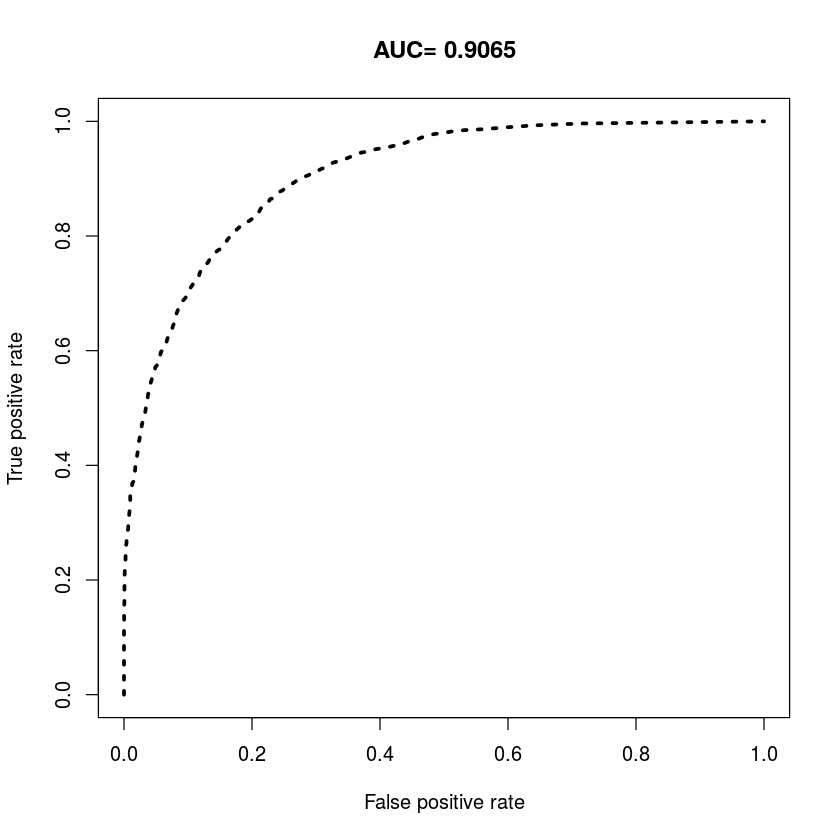

In [9]:
pred_test <- predict(rf_model, testing_data, type='prob')
library(ROCR)
pred <- prediction(pred_test[,2], testing_data[,"income"])
perf <- performance(pred,"tpr","fpr")

auc <- performance(pred,"auc")
plot(perf,col="black",lty=3, lwd=3, main=paste("AUC=", round(unlist(slot(auc, "y.values")),4)))

# Speed up RF Training by Parallelization

In [10]:
library(doSNOW)
library(foreach)
library(parallel)


# Setting number of cores in your machine. 
num_cores <- detectCores()
cl <- makeCluster(num_cores-1)
registerDoSNOW(cl)
ntrees <- 200

tic()
print(paste("Start training RF model with 200 trees using ", num_cores-1, " core", sep=""))

rf <- foreach(ntree = rep(round(ntrees/(num_cores-1)), num_cores-1), .combine = combine, .packages = "randomForest") %dopar% 
  randomForest(income~., data=training_data, ntree=ntree, mtry=3, 
                         importance=TRUE, nodesize=5, do.trace = TRUE)

print("Training 200 trees completed.")
toc()
stopCluster(cl)

Loading required package: foreach
Loading required package: iterators
Loading required package: snow

Attaching package: ‘parallel’

The following objects are masked from ‘package:snow’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, clusterSplit, makeCluster, parApply,
    parCapply, parLapply, parRapply, parSapply, splitIndices,
    stopCluster



[1] "Start training RF model with 200 trees using 3 core"
[1] "Training 200 trees completed."
7.422 sec elapsed


# Gradient Boosted Decision Trees

In [11]:
library(gbm)
training_data[,15] <- as.character(training_data[,15])
testing_data[,15] <- as.character(testing_data[,15])
training_data[training_data[,15]==' <=50K', 15] <- 0
training_data[training_data[,15]==' >50K', 15] <- 1
testing_data[testing_data[,15]==' <=50K', 15] <- 0
testing_data[testing_data[,15]==' >50K', 15] <- 1
training_data[,15] <- as.numeric(training_data[,15])
testing_data[,15] <- as.numeric(testing_data[,15])
ntrees <- 250
gbm_model <- gbm(formula = income ~ ., distribution =  "bernoulli", data = training_data, 
                 n.trees = ntrees, interaction.depth = 4, n.minobsinnode = 5, shrinkage = 0.01)

Loading required package: survival
Loading required package: lattice
Loading required package: splines
Loaded gbm 2.1.3


## Prediction Tests

In [12]:
pred_test <- predict(gbm_model, testing_data, n.trees = ntrees, type='response')
pred_test[pred_test > 0.5] <- 1
pred_test[pred_test <= 0.5] <- 0
accuracy <- sum(pred_test==testing_data[,"income"])/nrow(testing_data)*100
print(paste("The accuracy on testing data is ", round(accuracy, 2), "%", sep=""))

[1] "The accuracy on testing data is 85.3%"


## Check the ROC on testing data

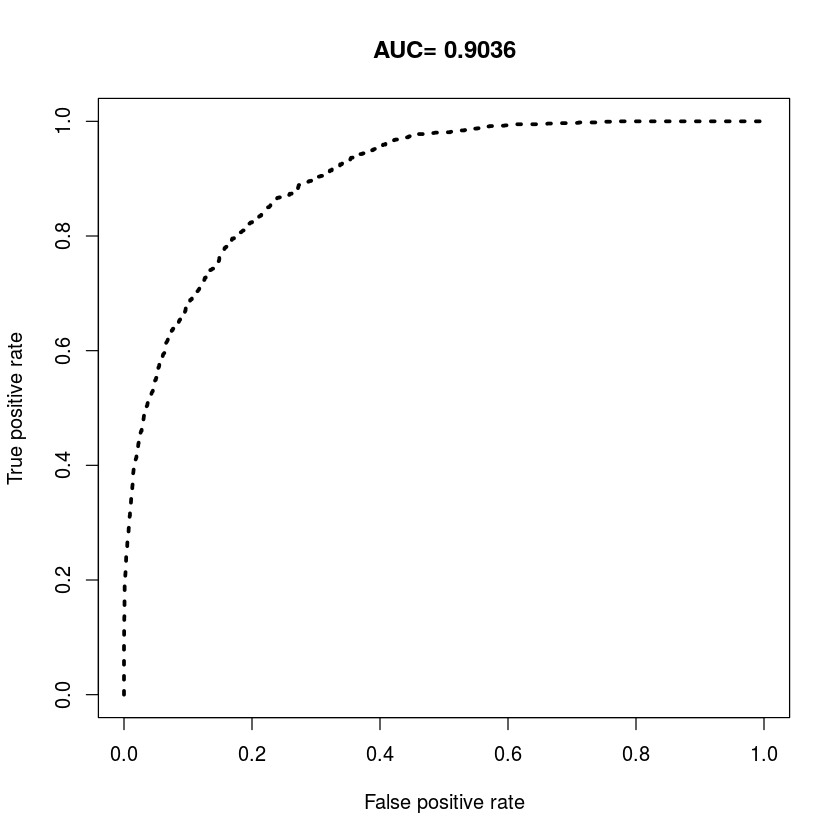

In [13]:
pred_test <- predict(gbm_model, testing_data, n.trees = ntrees, type='response')
library(ROCR)
pred <- prediction(pred_test, testing_data[,"income"])
perf <- performance(pred,"tpr","fpr")

auc <- performance(pred,"auc")
plot(perf,col="black",lty=3, lwd=3, main=paste("AUC=", round(unlist(slot(auc, "y.values")),4)))